In [63]:
import sys
sys.path.append('../')
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs, load_sample_complete_laps
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")
fname = '../logs/training-simulation-logs-v2.log'

full_df = load_logs(fname)
calculate_iteration(full_df)

full_df['duration'] = full_df[['episode','numeric_timestamp']].groupby('episode').transform(lambda x: x - x.min())
df = full_df
import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [64]:
df.head()

,episode,step,x-coordinate,y-coordinate,heading,steering_angle,speed,action_taken,reward,job_completed,all_wheels_on_track,progress,closest_waypoint_index,track_length,time,status,numeric_timestamp,iteration,duration
0,519,15,3.3707,0.3201,-14.2833,0.0,2.0,4,0.001,False,False,7.6066,2,17.67,2020-06-18 14:51:59,in_progress,1.592492e+09,26,0.920143
1,519,16,3.5075,0.2853,-14.2626,-10.0,4.0,3,0.001,True,False,8.3802,2,17.67,2020-06-18 14:51:59,off_track,1.592492e+09,26,0.988773
2,519,1,2.1626,0.6519,-14.1729,0.0,4.0,5,1.001,False,True,0.7704,68,17.67,2020-06-18 14:51:58,in_progress,1.592492e+09,26,0.000000
3,519,2,2.1653,0.6513,-14.1647,-10.0,4.0,3,1.001,False,True,0.7856,68,17.67,2020-06-18 14:51:58,in_progress,1.592492e+09,26,0.051695
4,519,3,2.1754,0.6484,-14.2884,-10.0,4.0,3,1.001,False,True,0.8428,68,17.67,2020-06-18 14:51:58,in_progress,1.592492e+09,26,0.117003


In [80]:
def get_info_by_episode(df,episode):
    cols = ['x-coordinate','y-coordinate','speed','action_taken','steerin','numeric_timestamp','step']
    return df.loc[df.episode == episode, :].sort_values('step')

def calculate_instantaneous_velocity(t,x,y):
    import scipy.linalg as la
    dx, dy, dt = numpy.diff([x,y,t],prepend=0)  
    v = la.norm([dx,dy],axis=0) / dt 
    return v

def plot_velocity_and_speed_action(ep,v):
    speed = ep.speed.values
    step = ep.step.values
    actions = ep.action_taken.values
    plt.figure(figsize=(9,6))
    plt.scatter(step,v,alpha=0.5,s=2)
    plt.plot(step,v,alpha=0.5)
    plt.scatter(step,speed,s=10,c=actions,cmap='Paired')
    plt.plot(step,speed,alpha=0.2,linestyle='--')
    plt.colorbar()
    plt.xlabel('Step')
    plt.ylabel('Instantaneous velocity (--) / Speed[Action] (continuos)')
    
def plot_velocity_on_track(track,x,y,v):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_aspect('equal')
    pu.print_border(ax,track)
    plt.scatter(x,y,c=v,cmap='hot')
    plt.colorbar(ax=ax,orientation='horizontal')
    
def plot_velocity_analysis(df,episode):
    ep = get_info_by_episode(df,episode)
    x,y,t = ep[['x-coordinate','y-coordinate','numeric_timestamp']].values.T
    v = calculate_instantaneous_velocity(t,x,y)
    ep['velocity'] = v

    plot_velocity_and_speed_action(ep,v)
    plot_velocity_on_track(track,x,y,v)

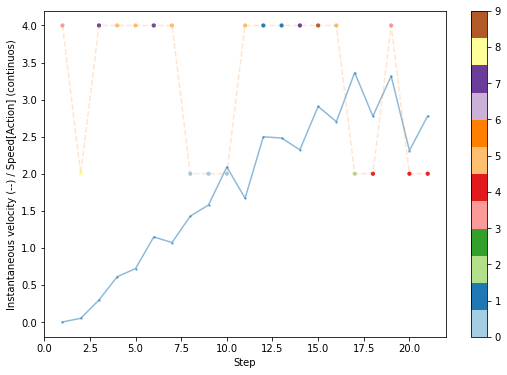

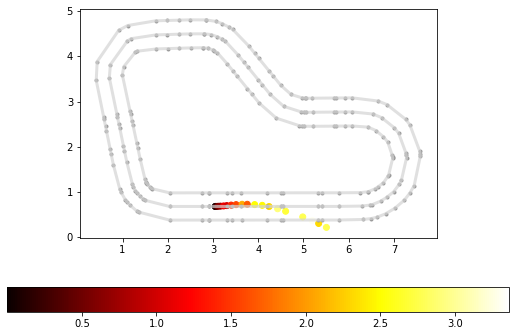

In [81]:
episode = 100
plot_velocity_analysis(df,episode)

# Use bqplot to add interactivity

In [67]:
from bqplot import Figure, LinearScale, Scatter, Lines, Axis, Tooltip
import bqplot.pyplot as blt

In [68]:
def plot_track(track, x, y):

    scales={'x': LinearScale(), 'y': LinearScale()}

    def plot_line(points, scales):
        x,y = points.T
        return Lines(x=x, y=y, scales=scales)

    def create_line(track,name,scales):
        points = getattr(track, name)
        return plot_line(points, scales)

    def create_track(track, scales):    
        return [ create_line(track,name,scales)
             for name in ['inner_border', 'outer_border','center_line']]

    def create_trajectory(x,y,scales):
        tooltip = Tooltip(fields=['x', 'y' ], formats=['.2f', '.2f'])
        return [ Lines(x=x, y=y, scales=scales ), Scatter(x=x, y=y, scales=scales, tooltip=tooltip ) ]

    def create_axes():
        return [ Axis(scale=scales['x'], label='x'), Axis(scale=scales['y'], orientation='vertical', label='y') ]

    marks = create_trajectory(x,y,scales) + create_track(track,scales)
    axes = create_axes()
    return Figure(marks=marks, axes=axes, title='L')

In [69]:
track_plot = plot_track(track,x,y)
track_plot

Figure(axes=[Axis(label='x', scale=LinearScale()), Axis(label='y', orientation='vertical', scale=LinearScale()…